In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.image as mpimg
%matplotlib inline

In [3]:

from keras.layers import Dense, Flatten, Activation, MaxPooling2D, Lambda
from keras.models import Sequential
from keras.layers.core import Lambda
from keras.layers.convolutional import Convolution2D
from keras.optimizers import SGD, Adam, RMSprop

Using TensorFlow backend.


In [9]:
# generator

# read the csv file
driving_df = pd.read_csv('data\driving_log.csv')

In [10]:
driving_df.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [11]:
for line in driving_df:
    print(1)

1
1
1
1
1
1
1


In [42]:
images = []
measurements = [] 

for index, row in driving_df.iterrows():
    print(row['center'])
    filename = row['center'][4:]
    print(filename)
    current_path = 'data/IMG/' + filename
    image = cv2.imread(current_path)
    #print(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    images.append(image)
    measurement = float(row['steering'])
    measurements.append(measurement)
    if index == 20:
        break
    

IMG/center_2016_12_01_13_30_48_287.jpg
center_2016_12_01_13_30_48_287.jpg
IMG/center_2016_12_01_13_30_48_404.jpg
center_2016_12_01_13_30_48_404.jpg
IMG/center_2016_12_01_13_31_12_937.jpg
center_2016_12_01_13_31_12_937.jpg
IMG/center_2016_12_01_13_31_13_037.jpg
center_2016_12_01_13_31_13_037.jpg
IMG/center_2016_12_01_13_31_13_177.jpg
center_2016_12_01_13_31_13_177.jpg
IMG/center_2016_12_01_13_31_13_279.jpg
center_2016_12_01_13_31_13_279.jpg
IMG/center_2016_12_01_13_31_13_381.jpg
center_2016_12_01_13_31_13_381.jpg
IMG/center_2016_12_01_13_31_13_482.jpg
center_2016_12_01_13_31_13_482.jpg
IMG/center_2016_12_01_13_31_13_584.jpg
center_2016_12_01_13_31_13_584.jpg
IMG/center_2016_12_01_13_31_13_686.jpg
center_2016_12_01_13_31_13_686.jpg
IMG/center_2016_12_01_13_31_13_786.jpg
center_2016_12_01_13_31_13_786.jpg
IMG/center_2016_12_01_13_31_13_890.jpg
center_2016_12_01_13_31_13_890.jpg
IMG/center_2016_12_01_13_31_13_991.jpg
center_2016_12_01_13_31_13_991.jpg
IMG/center_2016_12_01_13_31_14_092.jpg

8036


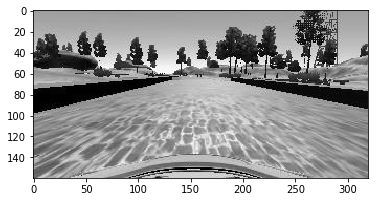

In [41]:
print(len(images))
gray = plt.imshow(images[0], cmap='gray')
#plt.imsave('gray_sample.jpg', gray)

In [34]:
from keras.layers import Cropping2D

In [ ]:
def generator(X_data, y_data):
    
    num_samples = len(data)
    
    for offset in range(0, num_samples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
    
    yield batch_x, batch_y
    
batch_x, batch_y = next(generator(X_data, y_data))